In [ ]:
!pip install vaderSentiment

# Amazon Review Binary Classification

### 0.1 Import packages

In [ ]:
# imports and connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 0.2 Load data, Print shape, columns, head

In [ ]:
# Read the CSV files copied into google drive above into pandas DataFrames
test = pd.read_csv('/content/gdrive/MyDrive/CS 74/Binary Classification/test.csv')
train = pd.read_csv('/content/gdrive/MyDrive/CS 74/Binary Classification/train.csv')

In [ ]:
# Displaying basic info about data
print(train.shape)
print(train.columns)
# of couse, test data does not have 'overall' column
print(test.shape)
print(test.columns)

# Displaying first few rows of training set
train.head(10)

(29189, 14)
Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style', 'category', 'id'],
      dtype='object')
(4500, 13)
Index(['verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'image', 'style',
       'category', 'id'],
      dtype='object')


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category,id
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive,ab0
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive,ab1
2,1,True,"09 17, 2014",74A9FA5A64449BEE2A2E8E3F62872F0F,A0E45600FF2C5A779CB4314F379C253A,C6E4DD5C1C4EC09E90182644ED6CA9EF,this wire set it really sucks!!!,One Star,1410912000,NaN,NaN,NaN,automotive,ab2
3,1,True,"06 11, 2016",EB561158A2829D98B467FE03CC1E45F1,37AB9A82470595E0ACB88BAC48C150EE,F4892A77EA45C52F40AB17ED537EF9FF,"first use, it leaked instantly. even at 5 buck...",One Star,1465603200,NaN,NaN,"{'Color:': ' Clear', 'Style:': ' 45 Degree'}",automotive,ab3
4,1,True,"12 23, 2017",5045D801332850D21618DD13A697CD9B,5772FF30428EEB8E0258C1A53CA2EC50,522F0BBFF2B47F1D63FF781A0AB1D079,didn't fit,One Star,1513987200,NaN,NaN,NaN,automotive,ab4
5,1,True,"04 16, 2017",068977D2F107CAA6195830CBF817EA36,9052916AEC3722F8B52039A39A11C896,657B3DA92EE342D7F1EEB4C0454E1448,i guess you get what you pay for.. i always go...,You get what you pay for..,1492300800,NaN,NaN,{'Size:': ' 2pcs 18w flood lights'},automotive,ab5
6,1,True,"12 26, 2016",241372EB529AC51C7CAF116574D69AE6,41CC78FA343926A2F7A04A32A3DE732F,C14E344017B2EC6D6B9E0AFAF8DE7912,you must remove the original black key fob cas...,Your Oriiginal Key Fob Warranty Could be Damaged!,1482710400,NaN,NaN,{'Color:': ' pink'},automotive,ab6
7,1,True,"05 17, 2017",C4100638BE92938306810B059E87487A,B009B497907125D1B14FAB2DEA079215,BEEF55AEBBD2C507C7C12EC3505432AC,"if you can't pull the wires off by hand, you w...",One Star,1494979200,NaN,NaN,NaN,automotive,ab7
8,1,True,"07 29, 2017",C87ACE9C5A7B9B9A29436F458F33EE20,6FA8FF9F211C9A01C827E09FD0D585D4,C191CB937036173A1101E5F155FB90B7,do not buy this junk! these mirrors are not ma...,Not a good product.,1501286400,NaN,NaN,NaN,automotive,ab8
9,1,True,"10 28, 2017",6D96F79D6279A1471DCAFCE62AC40901,C9E7E478351DEEC270E7F71FEB6B1F64,07FF419E7CC5C9D1722CB97D4F1551CA,not well made at all. led unit sits crooked in...,very disappointing,1509148800,NaN,NaN,{'Color:': ' Red'},automotive,ab9


### 0.3 Check for null values

In [ ]:
# note, in test pd columns 'vote', 'image', and 'style' have null values
print("# of null values in train per column")
train.isnull().sum()

# of null values in train per column


overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          4
reviewText            0
summary               5
unixReviewTime        0
vote              23142
image             28589
style             13824
category              0
id                    0
dtype: int64

In [ ]:
print(train.shape,train["asin"].nunique(),train["reviewerID"].nunique())

(29189, 14) 24102 27588


### 0.4 Preprocessing

In [ ]:
# Create overallBinary
train['overallBinary'] = train['overall'].apply(lambda rating: 1 if rating > 3 else 0)

# Create new column that turns verified columns into integers for both test and train
# 1 if true, 0 if false
train['verified_num'] = train['verified'].apply(lambda x: 1 if x == 'True' else 0)
test['verified_num'] = test['verified'].apply(lambda x: 1 if x == 'True' else 0)

# One-hot encoding of category as part of preprocessing
one_hot_encoded = pd.get_dummies(train["category"], prefix="category")
train = pd.concat([train, one_hot_encoded], axis=1)
one_hot_encoded = pd.get_dummies(test["category"], prefix="category")
test = pd.concat([test, one_hot_encoded], axis=1)

# Log unix review time
train['reviewTimeLog'] = np.log(train['unixReviewTime'] + 1)
test['reviewTimeLog'] = np.log(test['unixReviewTime'] + 1)

# Fill null values in vote
train['vote'].fillna(0, inplace=True)
test['vote'].fillna(0, inplace=True)

# Fill null values in summary
train['summary'].fillna('', inplace=True)
test['summary'].fillna('', inplace=True)

# Create summary_length
train['summary_length'] = train['summary'].apply(lambda x: len(str(x)))
test['summary_length'] = test['summary'].apply(lambda x: len(str(x)))

# Create reviewText_length
train['reviewText_length'] = train['reviewText'].apply(lambda x: len(str(x)))
test['reviewText_length'] = test['reviewText'].apply(lambda x: len(str(x)))

# log the length columns
train["summary_length_log"] = np.log(train.summary_length + 1)
test["summary_length_log"] = np.log(test.summary_length + 1)
train["reviewText_length_log"] = np.log(train.reviewText_length + 1)
test["reviewText_length_log"] = np.log(test.reviewText_length + 1)

### 0.5 TF-IDF - reviewText

In [ ]:
# Use TF-IDF to create reviewTextPredictBinary

# Initalize vectorizer
vectorizer = TfidfVectorizer()

# Fit vectorizer and transform text into features
train_features = vectorizer.fit_transform(train.reviewText.tolist())

# Create model that predicts classifier just from review text
model = LogisticRegression()
model.fit(train_features, train.overallBinary.tolist())

# Run model on train
transformed_data = vectorizer.transform(train['reviewText'])
predictions = model.predict(transformed_data)
train['reviewTextPredictBinary'] = predictions

# Run model on test
test_features = vectorizer.transform(test.reviewText.tolist())
test_predictions = model.predict(test_features)
test['reviewTextPredictBinary'] = test_predictions

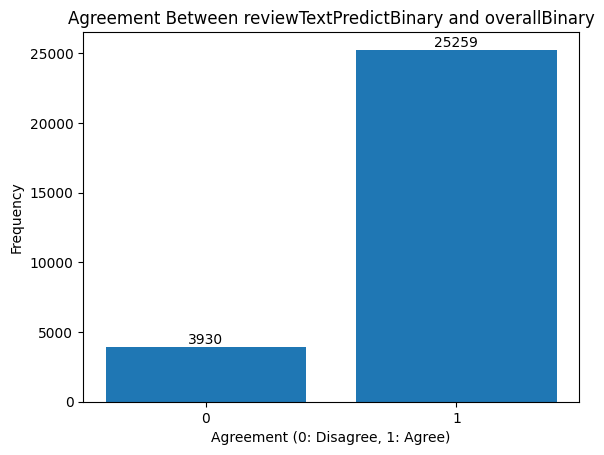

86.54% are correct


In [ ]:
# Visualize predictive accuracy of reviewTextPredictBinary

# Create 'agree' column to identify the rows where 'reviewTextPredictBinary equals 'overallBinary'
train['agree'] = (train['reviewTextPredictBinary'] == train['overallBinary']).astype(int)

# Create a histogram
hist, bins = np.histogram(train['agree'], bins=[0, 1, 2])

# Plot the histogram
plt.hist(train['agree'], bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title('Agreement Between reviewTextPredictBinary and overallBinary')
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')
plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")

### 0.6 TF-IDF - summary

In [ ]:
# use TF-IDF to create summaryPredictBinary

# Initalize vectorizer.
vectorizer = TfidfVectorizer()

# Fit vectorizer and transform text into features
train_features = vectorizer.fit_transform(train.summary.tolist())

# Create model that predicts classifier from summary text
model = LogisticRegression()
model.fit(train_features, train.overallBinary.tolist())

# Run model on train
transformed_data = vectorizer.transform(train['summary'])
predictions = model.predict(transformed_data)
train['summaryPredictBinary'] = predictions

# Run model on test
test_features = vectorizer.transform(test.summary.tolist())
test_predictions = model.predict(test_features)
test['summaryPredictBinary'] = test_predictions

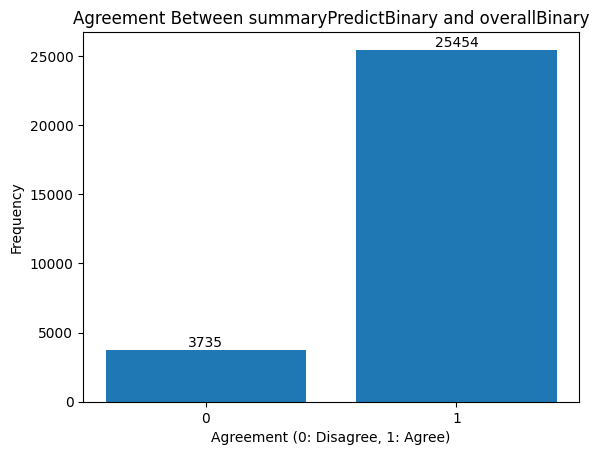

87.20% are correct


In [ ]:
# Visualize predictive accuracy of summaryPredictBinary

# Create 'agree_summ' column to identify the rows where 'summaryPredictBinary equals 'overallBinary'
train['agree_summ'] = (train['summaryPredictBinary'] == train['overallBinary']).astype(int)

# Create a histogram
hist, bins = np.histogram(train['agree_summ'], bins=[0, 1, 2])

# Plot the histogram
plt.hist(train['agree_summ'], bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title('Agreement Between summaryPredictBinary and overallBinary')

# Annotate the histogram with counts
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')

plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")

# Part 1

## 1.1 Visualize Data

### 1.1.1 Visualize Columns

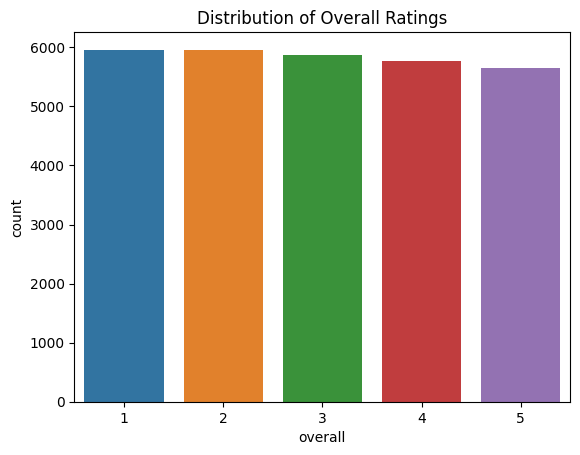

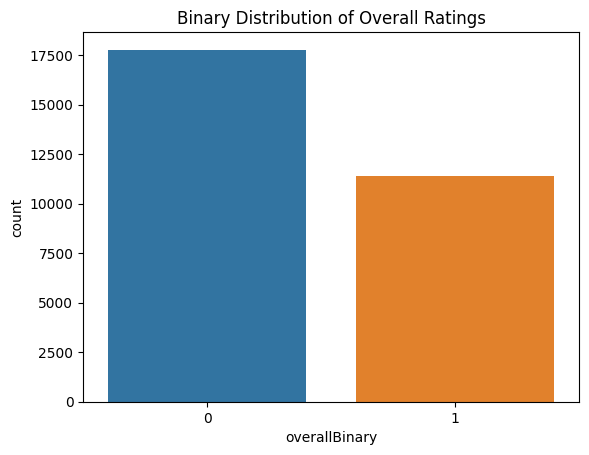

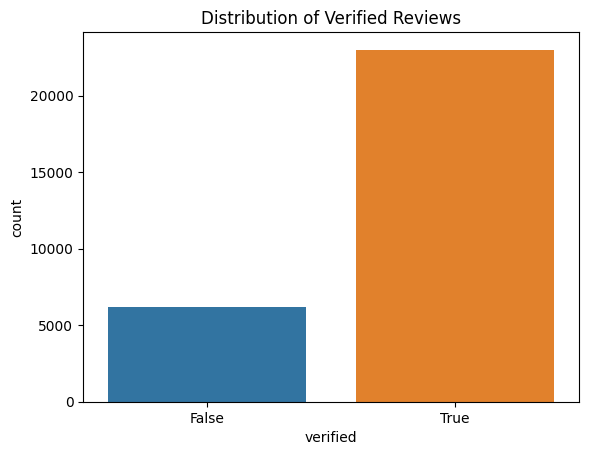

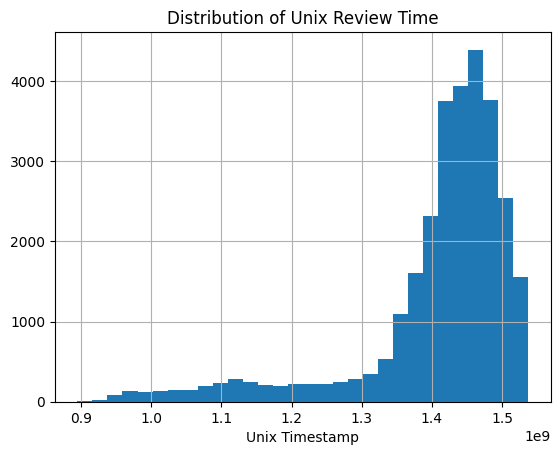

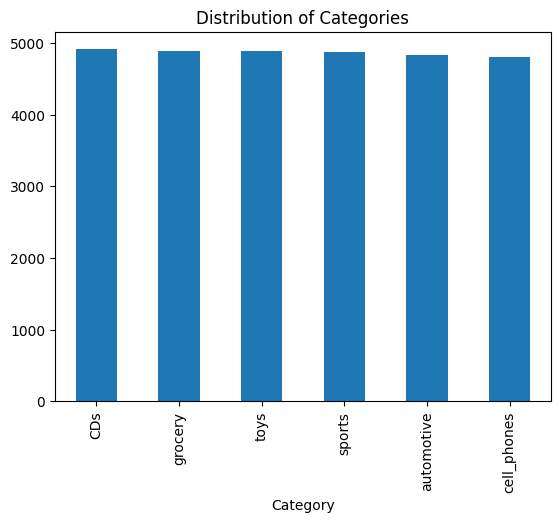

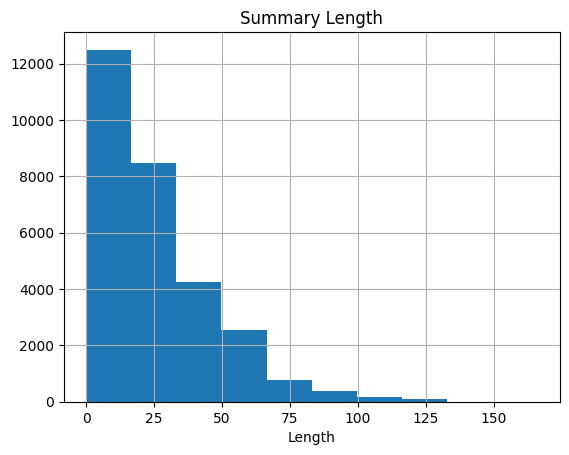

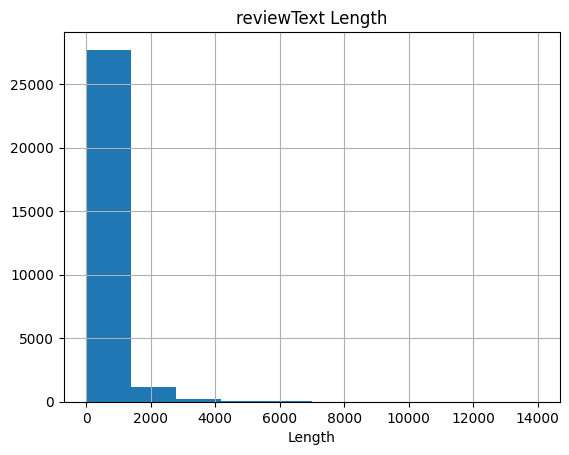

In [ ]:
# Visualize 'overall' and 'overallBinary' (target variable)
sns.countplot(x='overall', data=train)
plt.title('Distribution of Overall Ratings')
plt.show()

sns.countplot(x='overallBinary', data=train)
plt.title('Binary Distribution of Overall Ratings')
plt.show()

# Visualize the 'verified' attribute
sns.countplot(x='verified', data=train)
plt.title('Distribution of Verified Reviews')
plt.show()

# Visualize the 'unixReviewTime' attribute
train['unixReviewTime'].hist(bins=30)
plt.title('Distribution of Unix Review Time')
plt.xlabel('Unix Timestamp')
plt.show()

# Visualize the 'category id' attribute
train['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.show()

# Create a figure for the summary_length plot
train['summary_length'].hist(bins=10)
plt.title('Summary Length')
plt.xlabel('Length')
plt.show()

# Create a figure for the reviewText_length plot
train['reviewText_length'].hist(bins=10)
plt.title('reviewText Length')
plt.xlabel('Length')
plt.show()

### 1.1.2 Visualize Relationship w/ Overall_Binary

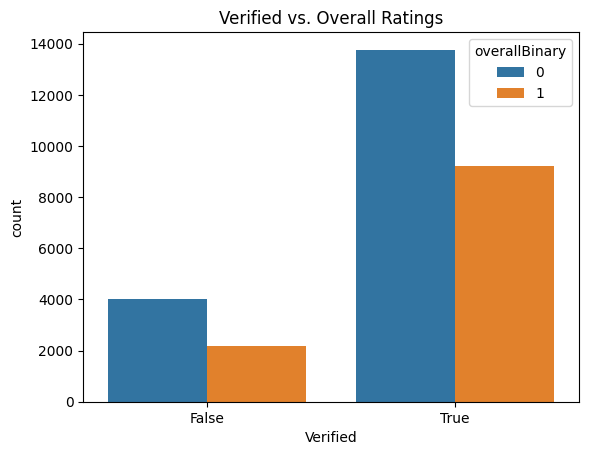

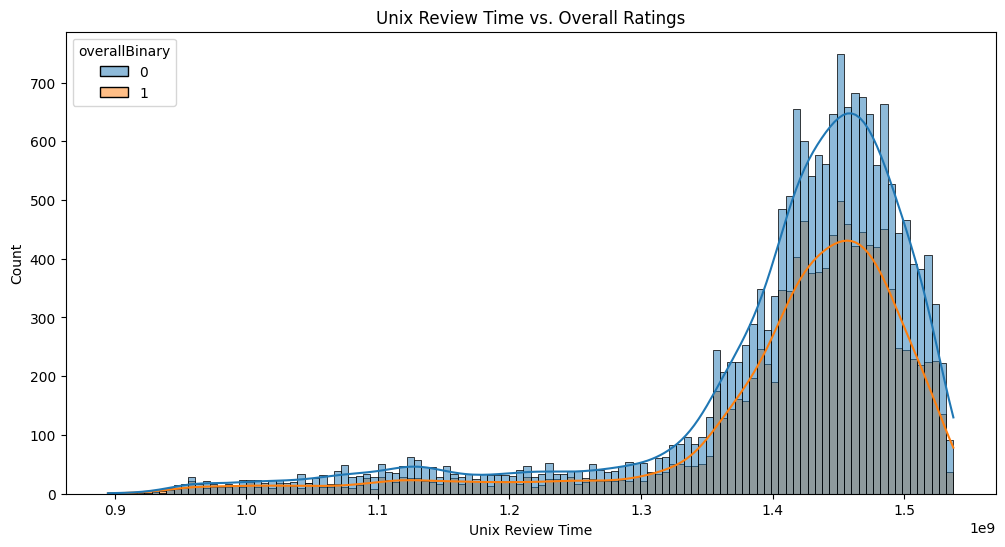

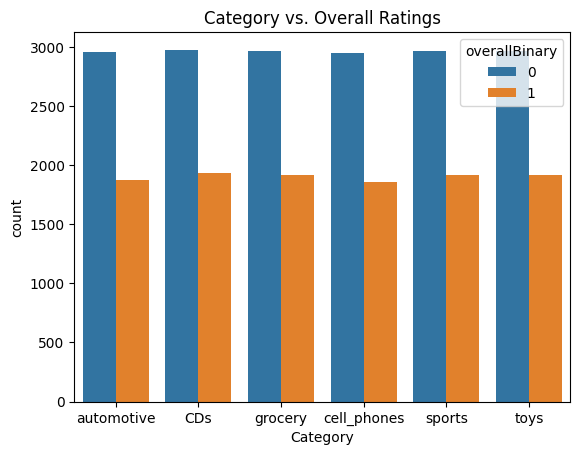

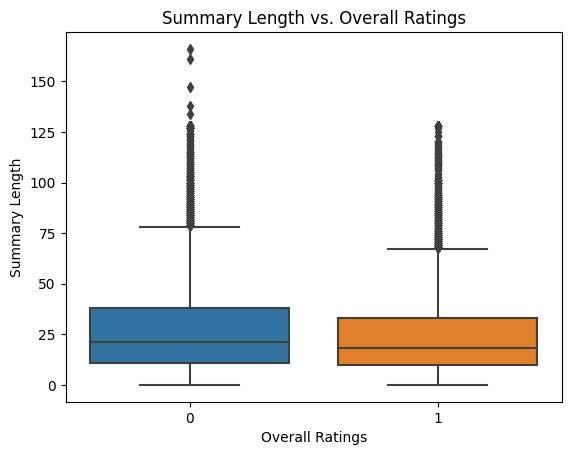

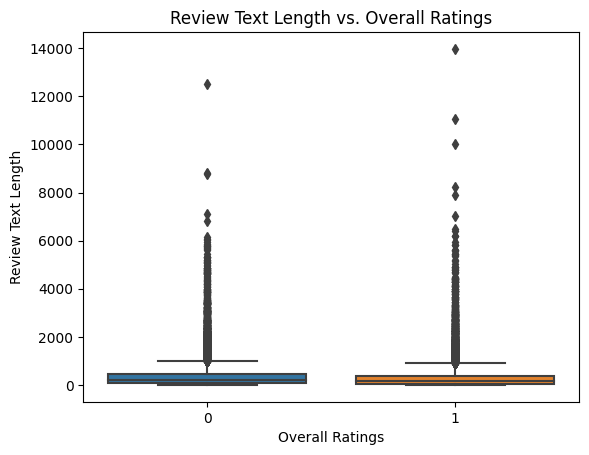

In [ ]:
# 'verified' vs. overallBinary
sns.countplot(data=train, x='verified', hue='overallBinary')
plt.title('Verified vs. Overall Ratings')
plt.xlabel('Verified')
plt.show()

# 'unixReviewTime' vs. overall_binary
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='unixReviewTime', hue='overallBinary', kde=True)
plt.title('Unix Review Time vs. Overall Ratings')
plt.xlabel('Unix Review Time')
plt.show()

# 'category' vs. overall_binary
sns.countplot(data=train, x='category', hue='overallBinary')
plt.title('Category vs. Overall Ratings')
plt.xlabel('Category')
plt.show()

# 'summary_length' vs. overall_binary
sns.boxplot(data=train, x='overallBinary', y='summary_length')
plt.title('Summary Length vs. Overall Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Summary Length')
plt.show()

# 'reviewText_length' vs. overall_binary
sns.boxplot(data=train, x='overallBinary', y='reviewText_length')
plt.title('Review Text Length vs. Overall Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Review Text Length')
plt.show()

### 1.1.3 Correlation Matrix (Train)

In [ ]:
train.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style', 'category', 'id', 'overallBinary', 'verified_num',
       'category_CDs', 'category_automotive', 'category_cell_phones',
       'category_grocery', 'category_sports', 'category_toys', 'reviewTimeLog',
       'summary_length', 'reviewText_length', 'summary_length_log',
       'reviewText_length_log', 'reviewTextPredictBinary', 'agree',
       'summaryPredictBinary', 'agree_summ'],
      dtype='object')

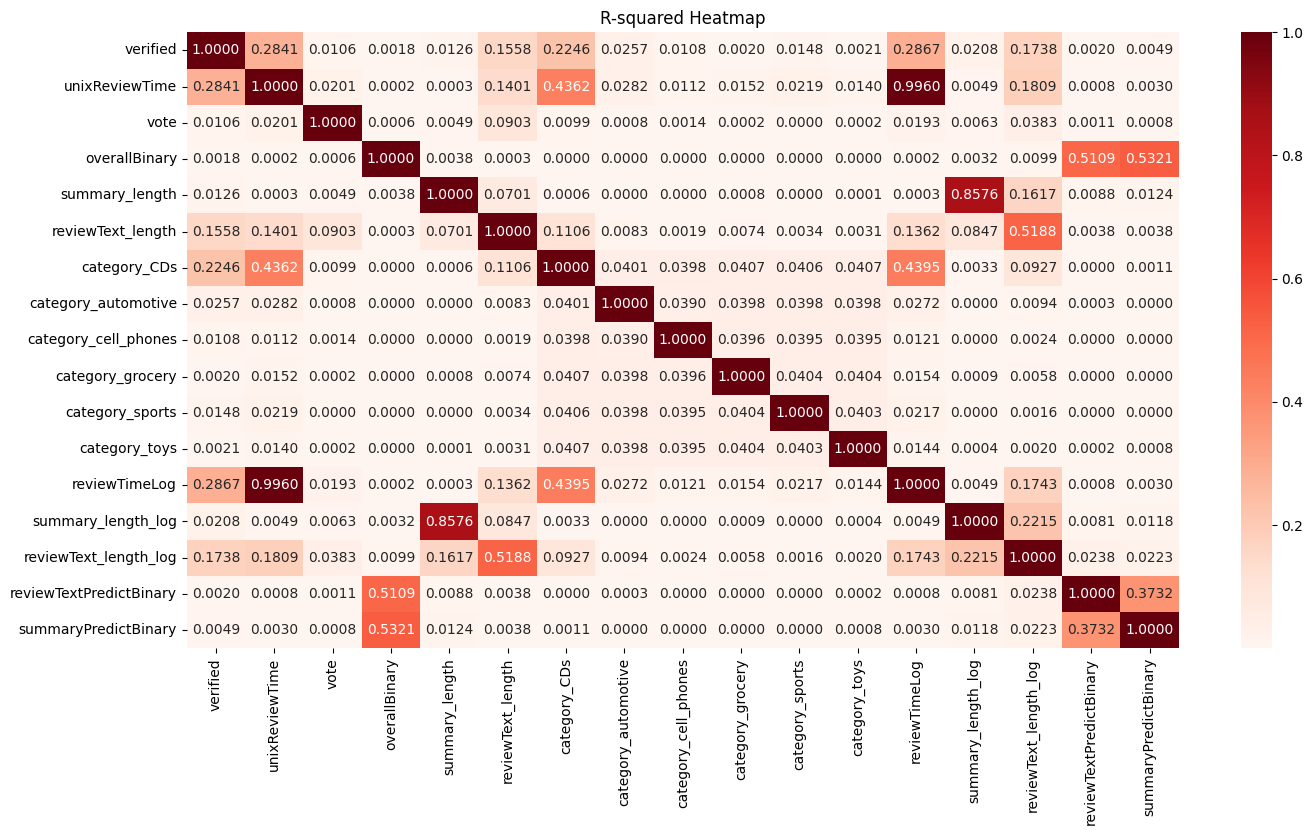

In [ ]:
columns = ['verified', 'unixReviewTime', 'vote', 'overallBinary',
           'summary_length', 'reviewText_length', 'category_CDs', 'category_automotive',
           'category_cell_phones', 'category_grocery', 'category_sports', 'category_toys', 'reviewTimeLog', 'summary_length_log',
       'reviewText_length_log', 'reviewTextPredictBinary', 'summaryPredictBinary']

rsquared_matrix = train[columns].corr() ** 2

# Create a
plt.figure(figsize=(16, 8))
sns.heatmap(rsquared_matrix, annot=True, cmap="Reds", fmt=".4f")
plt.title("R-squared Heatmap")
plt.show()

## 1.2 Create Model

### 1.2.1 Model Preparation

In [ ]:
train.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style', 'category', 'id', 'overallBinary', 'verified_num',
       'category_CDs', 'category_automotive', 'category_cell_phones',
       'category_grocery', 'category_sports', 'category_toys', 'reviewTimeLog',
       'summary_length', 'reviewText_length', 'summary_length_log',
       'reviewText_length_log', 'reviewTextPredictBinary', 'agree',
       'summaryPredictBinary', 'agree_summ', 'summaryCompound',
       'summaryPositive', 'summaryNegative', 'summaryNeutral',
       'reviewTextCompound', 'reviewTextPositive', 'reviewTextNegative',
       'reviewTextNeutral', 'binary_reviewText_sentiment_score',
       'binary_summary_sentiment_score'],
      dtype='object')

In [ ]:
# Define features
features = ['reviewTextPredictBinary', 'verified_num', 'category_CDs','category_automotive', 'category_cell_phones', 'category_grocery',
       'category_sports', 'category_toys', 'reviewTimeLog','summaryPredictBinary','summary_length_log', 'reviewText_length_log', 'vote']

In [ ]:
# Split into training and test (use for testing models)
X_train, X_test, y_train, y_test = train_test_split(train[features], train['overallBinary'], test_size=0.2, random_state=42)

### 1.2.2 Logistic Regression

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.1, 0.1)}

# Create a Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['logRegPred'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 0.1}
Mean Accuracy: 0.8928099985467762
Logistic Regression Model (Test Set):
Test Accuracy: 0.8982528263103803
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      3576
           1       0.84      0.91      0.87      2262

    accuracy                           0.90      5838
   macro avg       0.89      0.90      0.89      5838
weighted avg       0.90      0.90      0.90      5838

Confusion Matrix:
[[3193  383]
 [ 211 2051]]
ROC AUC Score: 0.9394942113352204
Macro F1 Score: 0.8942045415716846


### 1.2.3 SVC

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.2, 0.5)}

# Create an SVM (Support Vector Machine) model
model = SVC(probability=True)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['SVC_Predict'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("SVM Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 2.1}
Mean Accuracy: 0.8902832869631151
SVM Model (Test Set):
Test Accuracy: 0.893456663240836
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3576
           1       0.84      0.90      0.87      2262

    accuracy                           0.89      5838
   macro avg       0.89      0.89      0.89      5838
weighted avg       0.90      0.89      0.89      5838

Confusion Matrix:
[[3177  399]
 [ 223 2039]]
ROC AUC Score: 0.938462923072967
Macro F1 Score: 0.889248365215694


### 1.2.3 Random Forest Classifier

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Random Forest model
model = RandomForestClassifier()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the validation and test sets
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['RF_Predict'] = best_model.predict(test[features])

# Evaluate the model's performance on the validation set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest Model (Validation Set):")
print(f'Validation Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Mean Accuracy: 0.9030879585505719
Random Forest Model (Validation Set):
Validation Accuracy: 0.9042480301473107
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3576
           1       0.88      0.87      0.88      2262

    accuracy                           0.90      5838
   macro avg       0.90      0.90      0.90      5838
weighted avg       0.90      0.90      0.90      5838

Confusion Matrix:
[[3301  275]
 [ 284 1978]]
ROC AUC Score: 0.9548726083310091
Macro F1 Score: 0.8990643764837314


## 1.3 Save Submission

In [ ]:
# all 3 beat the baseline

submission_data = {'id': test['id'], 'preds': test['logRegPred']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("logregression.csv", index = False)


submission_data = {'id': test['id'], 'preds': test['SVC_Predict']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("SVC_Predict.csv", index = False)

submission_data = {'id': test['id'], 'preds': test['RF_Predict']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("RF_Predict.csv", index = False)


# Part 2

## 2.1 Sentiment Analysis

In [ ]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to perform sentiment analysis and return scores
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis and add columns for 'compound', 'positive', 'negative', and 'neutral' scores
train_sentiment_summary = train['summary'].apply(analyze_sentiment)
train_sentiment_reviewText = train['reviewText'].apply(analyze_sentiment)

train['summaryCompound'] = [score['compound'] for score in train_sentiment_summary]
train['summaryPositive'] = [score['pos'] for score in train_sentiment_summary]
train['summaryNegative'] = [score['neg'] for score in train_sentiment_summary]
train['summaryNeutral'] = [score['neu'] for score in train_sentiment_summary]

train['reviewTextCompound'] = [score['compound'] for score in train_sentiment_reviewText]
train['reviewTextPositive'] = [score['pos'] for score in train_sentiment_reviewText]
train['reviewTextNegative'] = [score['neg'] for score in train_sentiment_reviewText]
train['reviewTextNeutral'] = [score['neu'] for score in train_sentiment_reviewText]

# Repeat the same process for the test DataFrame

test_sentiment_summary = test['summary'].apply(analyze_sentiment)
test_sentiment_reviewText = test['reviewText'].apply(analyze_sentiment)

test['summaryCompound'] = [score['compound'] for score in test_sentiment_summary]
test['summaryPositive'] = [score['pos'] for score in test_sentiment_summary]
test['summaryNegative'] = [score['neg'] for score in test_sentiment_summary]
test['summaryNeutral'] = [score['neu'] for score in test_sentiment_summary]

test['reviewTextCompound'] = [score['compound'] for score in test_sentiment_reviewText]
test['reviewTextPositive'] = [score['pos'] for score in test_sentiment_reviewText]
test['reviewTextNegative'] = [score['neg'] for score in test_sentiment_reviewText]
test['reviewTextNeutral'] = [score['neu'] for score in test_sentiment_reviewText]

In [ ]:
train['binary_reviewText_sentiment_score'] = train['reviewTextCompound'].apply(lambda score: 1 if score > 0 else 0 if score < 0 else np.random.randint(2))
test['binary_reviewText_sentiment_score'] = test['reviewTextCompound'].apply(lambda score: 1 if score > 0 else 0 if score < 0 else np.random.randint(2))
train['binary_summary_sentiment_score'] = train['summaryCompound'].apply(lambda score: 1 if score > 0 else 0 if score < 0 else np.random.randint(2))
test['binary_summary_sentiment_score'] = test['summaryCompound'].apply(lambda score: 1 if score > 0 else 0 if score < 0 else np.random.randint(2))

### 2.1.2 Visualize Sentiment Scores

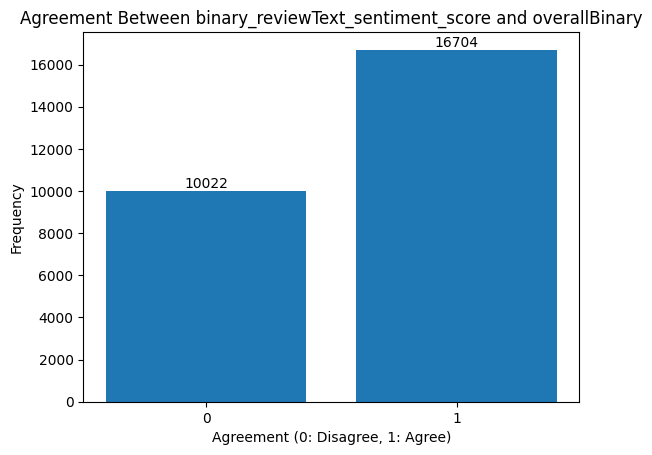

62.50% are correct


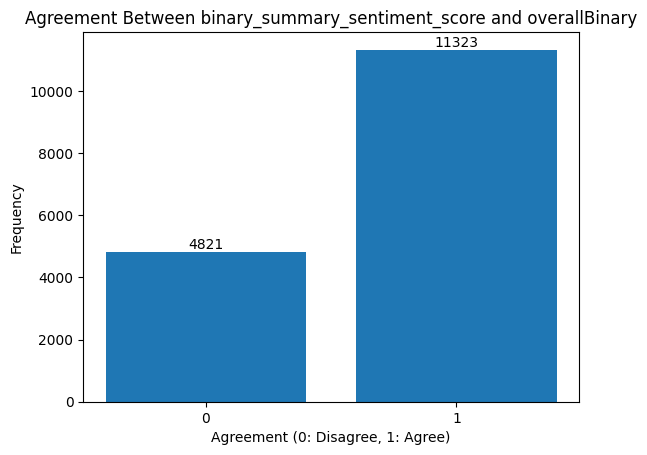

70.14% are correct


In [ ]:
# ReviewText
filtered_ss = train.loc[np.abs(train['reviewTextCompound']) != 0, 'binary_reviewText_sentiment_score']
filtered_overall = train.loc[np.abs(train['reviewTextCompound']) != 0, 'overallBinary']
agree = (filtered_overall == filtered_ss).astype(int)

# Create a histogram
hist, bins = np.histogram(agree, bins=[0, 1, 2])

# Plot the histogram
plt.hist(agree, bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title('Agreement Between binary_reviewText_sentiment_score and overallBinary')

# Annotate the histogram with counts
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')

plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")


# Summary
filtered_ss = train.loc[np.abs(train['summaryCompound']) != 0, 'binary_summary_sentiment_score']
filtered_overall = train.loc[np.abs(train['summaryCompound']) != 0, 'overallBinary']
agree = (filtered_overall == filtered_ss).astype(int)

# Create a histogram
hist, bins = np.histogram(agree, bins=[0, 1, 2])

# Plot the histogram
plt.hist(agree, bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title('Agreement Between binary_summary_sentiment_score and overallBinary')

# Annotate the histogram with counts
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')

plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")

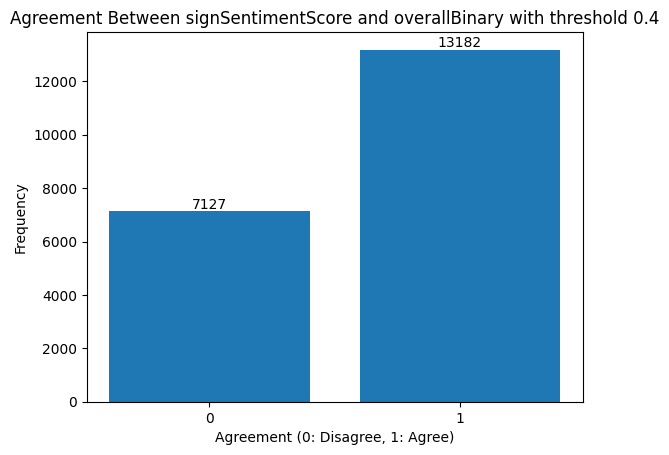

64.91% are correct


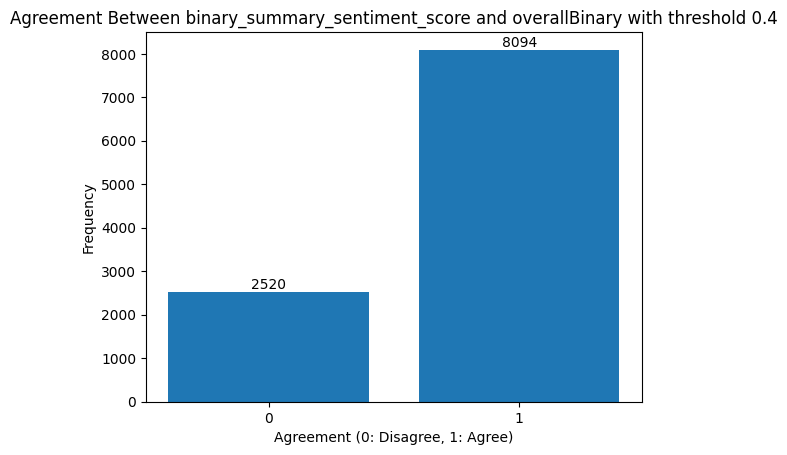

76.26% are correct


In [ ]:
# ReviewText
# A couple percentage points more accurate with threshold
threshold = 0.4
filtered_ss = train.loc[np.abs(train['reviewTextCompound']) > threshold, 'binary_reviewText_sentiment_score']
filtered_overall = train.loc[np.abs(train['reviewTextCompound']) > threshold, 'overallBinary']
agree = (filtered_overall == filtered_ss).astype(int)

# Create a histogram
hist, bins = np.histogram(agree, bins=[0, 1, 2])

# Plot the histogram
plt.hist(agree, bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title(f"Agreement Between signSentimentScore and overallBinary with threshold {threshold}")

# Annotate the histogram with counts
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')

plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")


# Summary
# A couple percentage points more accurate with threshold
threshold = 0.4
filtered_ss = train.loc[np.abs(train['summaryCompound']) > threshold, 'binary_summary_sentiment_score']
filtered_overall = train.loc[np.abs(train['summaryCompound']) > threshold, 'overallBinary']
agree = (filtered_overall == filtered_ss).astype(int)

# Create a histogram
hist, bins = np.histogram(agree, bins=[0, 1, 2])

# Plot the histogram
plt.hist(agree, bins=[0, 1, 2], align='left', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Agreement (0: Disagree, 1: Agree)')
plt.ylabel('Frequency')
plt.title(f"Agreement Between binary_summary_sentiment_score and overallBinary with threshold {threshold}")

# Annotate the histogram with counts
for i in range(len(hist)):
    plt.annotate(str(hist[i]), xy=(bins[i], hist[i]), ha='center', va='bottom')

plt.show()

percentage_correct = (hist[1] / sum(hist)) * 100
print(f"{percentage_correct:.2f}% are correct")

## 2.2 Create Model w/ Only Sentiment Scores

### 2.2.1 Model Preparation

In [ ]:
# Define features
features = [
    'summaryCompound', 'summaryPositive', 'summaryNegative', 'summaryNeutral',
    'reviewTextCompound', 'reviewTextPositive', 'reviewTextNegative', 'reviewTextNeutral',
    'binary_reviewText_sentiment_score', 'binary_summary_sentiment_score'
]

In [ ]:
# Split into training and test (use for testing models -- not for creating submission models)
X_train, X_test, y_train, y_test = train_test_split(train[features], train['overallBinary'], test_size=0.2, random_state=42)

### 2.2.2 Create Model SVC



In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.2, 0.5)}

# Create an SVM (Support Vector Machine) model
model = SVC(probability=True)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['SVM_Predict_Sentiment'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("SVM Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 2.1}
Mean Accuracy: 0.78386364084375
SVM Model (Test Set):
Test Accuracy: 0.7946214457005824
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      3576
           1       0.76      0.69      0.72      2262

    accuracy                           0.79      5838
   macro avg       0.79      0.77      0.78      5838
weighted avg       0.79      0.79      0.79      5838

Confusion Matrix:
[[3089  487]
 [ 712 1550]]
ROC AUC Score: 0.8421034250341702
Macro F1 Score: 0.7792828675460146


### 2.2.3 Create Model Logistic Regression

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.1, 0.1)}

# Create a Logistic Regression model
model = LogisticRegression()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['logRegPredSentiment'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 0.5}
Mean Accuracy: 0.7784677611230074
Logistic Regression Model (Test Set):
Test Accuracy: 0.7913669064748201
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3576
           1       0.75      0.69      0.72      2262

    accuracy                           0.79      5838
   macro avg       0.78      0.77      0.78      5838
weighted avg       0.79      0.79      0.79      5838

Confusion Matrix:
[[3051  525]
 [ 693 1569]]
ROC AUC Score: 0.8575621171302148
Macro F1 Score: 0.7769961161540894


### 2.2.4 Create Model Random Forrest



In [ ]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 5]}

# Create a Random Forest model
model = RandomForestClassifier()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_

# # Hard-coded parameters:
# best_model = RandomForestClassifier(
#     random_state=42,
#     max_depth=20,
#     min_samples_leaf=4,
#     min_samples_split=10,
#     n_estimators=100)
# best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test['RF_Sentiment_Predict'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Accuracy: 0.7904158008065622
Random Forest Model (Test Set):
Test Accuracy: 0.7994176087701268
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      3576
           1       0.77      0.69      0.73      2262

    accuracy                           0.80      5838
   macro avg       0.79      0.78      0.78      5838
weighted avg       0.80      0.80      0.80      5838

Confusion Matrix:
[[3102  474]
 [ 697 1565]]
ROC AUC Score: 0.8658309671313027
Macro F1 Score: 0.7844790371967103


## 2.3 Recreate Pt.1 Model w/ Sentiment Scores

### 2.3.1 Model Preparation

In [ ]:
# Define features
features = ['vote','reviewTextPredictBinary', 'verified_num', 'category_CDs','category_automotive',
            'category_cell_phones', 'category_grocery','category_sports', 'category_toys', 'reviewTimeLog',
            'summaryPredictBinary','summary_length_log', 'reviewText_length_log', 'summaryCompound', 'summaryPositive',
            'summaryNegative', 'summaryNeutral', 'reviewTextCompound', 'reviewTextPositive', 'reviewTextNegative',
            'reviewTextNeutral','binary_reviewText_sentiment_score', 'binary_summary_sentiment_score']

In [ ]:
# Split into training and validation (use for testing models)
X_train, X_test, y_train, y_test = train_test_split(train[features], train['overallBinary'], test_size=0.2, random_state=42)

### 2.3.2 Random Forest Classifier Sentiment + Text

In [ ]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 5]}

# Create a Random Forest model
model = RandomForestClassifier()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_

# # W/ hard-coded parameters
# best_model = RandomForestClassifier(
#     random_state=42,
#     max_depth=10,
#     min_samples_leaf=5,
#     min_samples_split=5,
#     n_estimators=200)
# best_model.fit(X_train, y_train)

test['RF_Sentiment+Text_Predict'] = best_model.predict(test[features])
y_pred = best_model.predict(X_test)

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Random Forest Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Accuracy: 0.9033877444178098
Random Forest Model (Test Set):
Test Accuracy: 0.9052757793764988
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3576
           1       0.88      0.88      0.88      2262

    accuracy                           0.91      5838
   macro avg       0.90      0.90      0.90      5838
weighted avg       0.91      0.91      0.91      5838

Confusion Matrix:
[[3304  272]
 [ 281 1981]]
ROC AUC Score: 0.9554835063108612
Macro F1 Score: 0.9001477642137807


### 2.3.3 Logistic Regression Sentiment + Text

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.1, 0.1)}

# Create a Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['LR_Sentiment+Text_Predict'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Logistic Regression Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 0.1}
Mean Accuracy: 0.8929383131692795
Logistic Regression Model (Test Set):
Test Accuracy: 0.8975676601575883
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3576
           1       0.85      0.89      0.87      2262

    accuracy                           0.90      5838
   macro avg       0.89      0.90      0.89      5838
weighted avg       0.90      0.90      0.90      5838

Confusion Matrix:
[[3233  343]
 [ 255 2007]]
ROC AUC Score: 0.9487889100536636
Macro F1 Score: 0.8928418307060513


### 2.3.4 SVC Sentiment + Text

In [ ]:
# Define the hyperparameter grid using np.arange
param_grid = {'C': np.arange(0.1, 2.2, 0.5)}

# Create an SVM (Support Vector Machine) model
model = SVC(probability=True)

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Get the mean accuracy from cross-validation
mean_accuracy = grid_search.best_score_

print("SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Accuracy: {mean_accuracy}')

# Now, let's evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test['SVM_Sentiment+Text_Predict'] = best_model.predict(test[features])

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("SVM Model (Test Set):")
print(f'Test Accuracy: {accuracy}')
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC and AUC
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Calculate macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

SVM Model with Hyperparameter Tuning and K-fold Cross-Validation:
Best Hyperparameters: {'C': 1.1}
Mean Accuracy: 0.8907972055926654
SVM Model (Test Set):
Test Accuracy: 0.8931140801644398
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3576
           1       0.84      0.90      0.87      2262

    accuracy                           0.89      5838
   macro avg       0.89      0.89      0.89      5838
weighted avg       0.90      0.89      0.89      5838

Confusion Matrix:
[[3180  396]
 [ 228 2034]]
ROC AUC Score: 0.9383574700775581
Macro F1 Score: 0.8888302967982352


## 2.4 Save Submission

In [ ]:

submission_data = {'id': test['id'], 'preds': test['RF_Sentiment+Text_Predict']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("RF_Sentiment+Text_Predict.csv", index = False)

submission_data = {'id': test['id'], 'preds': test['LR_Sentiment+Text_Predict']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("LR_Sentiment+Text_Predict.csv", index = False)

submission_data = {'id': test['id'], 'preds': test['SVM_Sentiment+Text_Predict']}
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("SVM_Sentiment+Text_Predict.csv", index = False)